<a href="https://colab.research.google.com/github/vicben2/hgraph2graph/blob/main/Partc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/wengong-jin/hgraph2graph

Cloning into 'hgraph2graph'...
remote: Enumerating objects: 364, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 364 (delta 113), reused 92 (delta 92), pack-reused 212 (from 1)
Receiving objects: 100% (364/364), 153.12 MiB | 23.65 MiB/s, done.
Resolving deltas: 100% (218/218), done.
Updating files: 100% (89/89), done.


In [2]:
%cd hgraph2graph

/content/hgraph2graph


In [3]:
!pip install rdkit networkx tqdm
import torch
from torch.utils.data import DataLoader
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, DataStructs
from rdkit import DataStructs
from hgraph import HierVAE, MolGraph, common_atom_vocab, Vocab, PairVocab
from hgraph import MoleculeDataset
import sys
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 60.2 MB/s eta 0:00:00


In [5]:
class Args:
  def __init__(self):
    self.vocab = None
    self.atom_vocab = common_atom_vocab
    self.rnn_type = 'LSTM'
    self.hidden_size = 250
    self.embed_size = 250
    self.batch_size = 20
    self.latent_size = 32
    self.depthT = 15
    self.depthG = 15
    self.diterT = 1
    self.diterG = 3
    self.dropout = 0.0

args = Args()

seed = 7

torch.manual_seed(seed)
random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#vocab
vocab_path = 'data/chembl/vocab.txt'
vocab_list = [x.strip("\r\n ").split() for x in open(vocab_path)] # Renamed to vocab_list to avoid confusion
args.vocab = PairVocab(vocab_list, cuda=(device.type == 'cuda')) # FIX: Explicitly pass cuda argument

import hgraph.hgnn as hgnn

def make_cuda_fixed(tensors):
    tree_tensors, graph_tensors = tensors
    def make_tensor(x):
        if isinstance(x, torch.Tensor):
            return x
        elif isinstance(x, np.ndarray):
            return torch.from_numpy(x)
        else:
            return torch.tensor(x)
    tree_tensors = [make_tensor(x).to(device).long() for x in tree_tensors[:-1]] + [tree_tensors[-1]]
    graph_tensors = [make_tensor(x).to(device).long() for x in graph_tensors[:-1]] + [graph_tensors[-1]]
    return tree_tensors, graph_tensors

hgnn.make_cuda = make_cuda_fixed

model = HierVAE(args).to(device)
pretrained_path = 'ckpt/chembl-pretrained/model.ckpt'
checkpoint = torch.load(pretrained_path, map_location=device)
pretrained_state = checkpoint[0] if isinstance(checkpoint, tuple) else checkpoint
model.load_state_dict(pretrained_state)
model.eval()

with open('data/chembl/all.txt', 'r') as f:
    all_smiles = [line.strip() for line in f][: 2000]

def filter_smiles(smiles_list, vocab, max_count=300):
    valid = []
    for smi in tqdm(smiles_list, desc="Begin filter"):
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol is None or mol.GetNumAtoms() > 40 or mol.GetNumAtoms() < 5:
                continue
            Chem.Kekulize(mol, clearAromaticFlags=False)
            hmol = MolGraph(smi)
            ok = True
            for node, attr in hmol.mol_tree.nodes(data=True):
                smiles_node = attr['smiles']
                ok &= attr['label'] in vocab.vmap
                for i, s in attr['inter_label']:
                    ok &= (smiles_node, s) in vocab.vmap
                if not ok:
                    break
            if ok:
                valid.append(smi)
                if len(valid) >= max_count:
                    break
        except:
            continue
    return valid

test_smiles = filter_smiles(all_smiles, args.vocab, max_count=250)

/usr/local/lib/python3.12/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Begin filter:  18%|█▊        | 359/2000 [00:04<00:21, 75.75it/s] 


After pruning 250 -> 250


Encoder representations: 100%|██████████| 25/25 [00:04<00:00,  5.27it/s]



Extracting molecular properties...


Analyzing decoding: 100%|██████████| 100/100 [00:01<00:00, 63.70it/s]
/tmp/ipython-input-935261987.py:328: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax6.boxplot(data_to_plot, labels=patterns_to_plot, patch_artist=True)
/tmp/ipython-input-935261987.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Analyzing failure modes...

Generating visualizations...


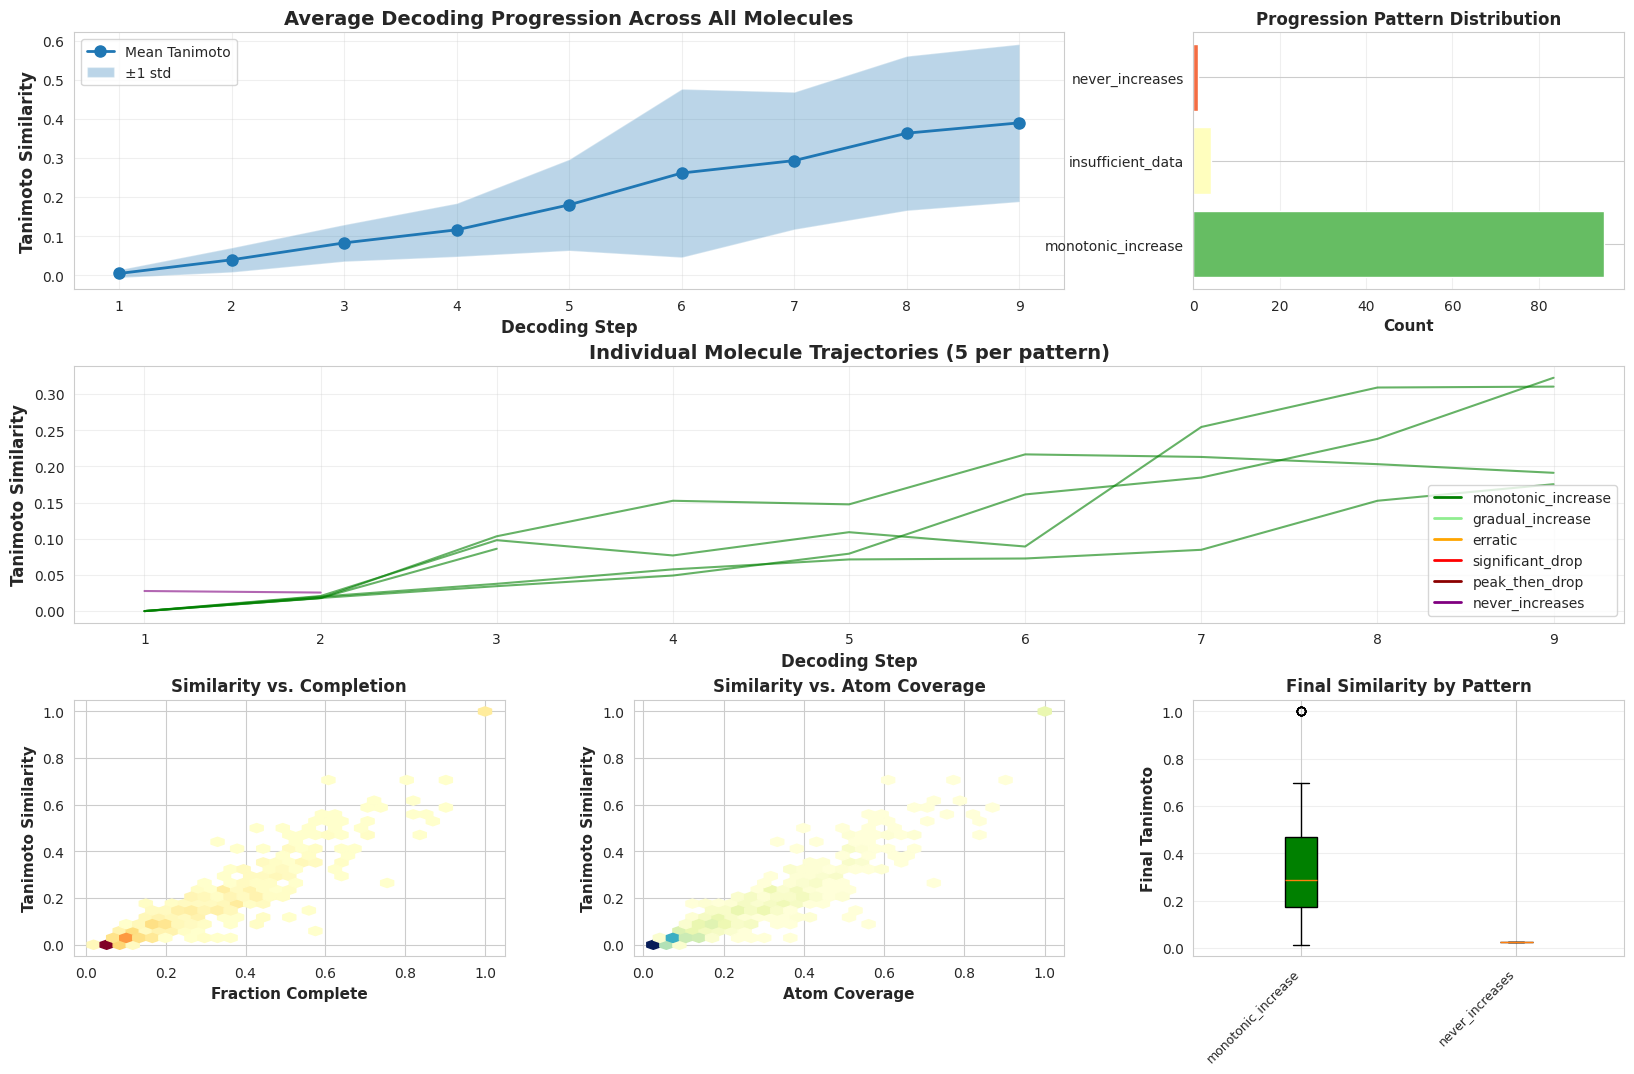

/tmp/ipython-input-935261987.py:369: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8)


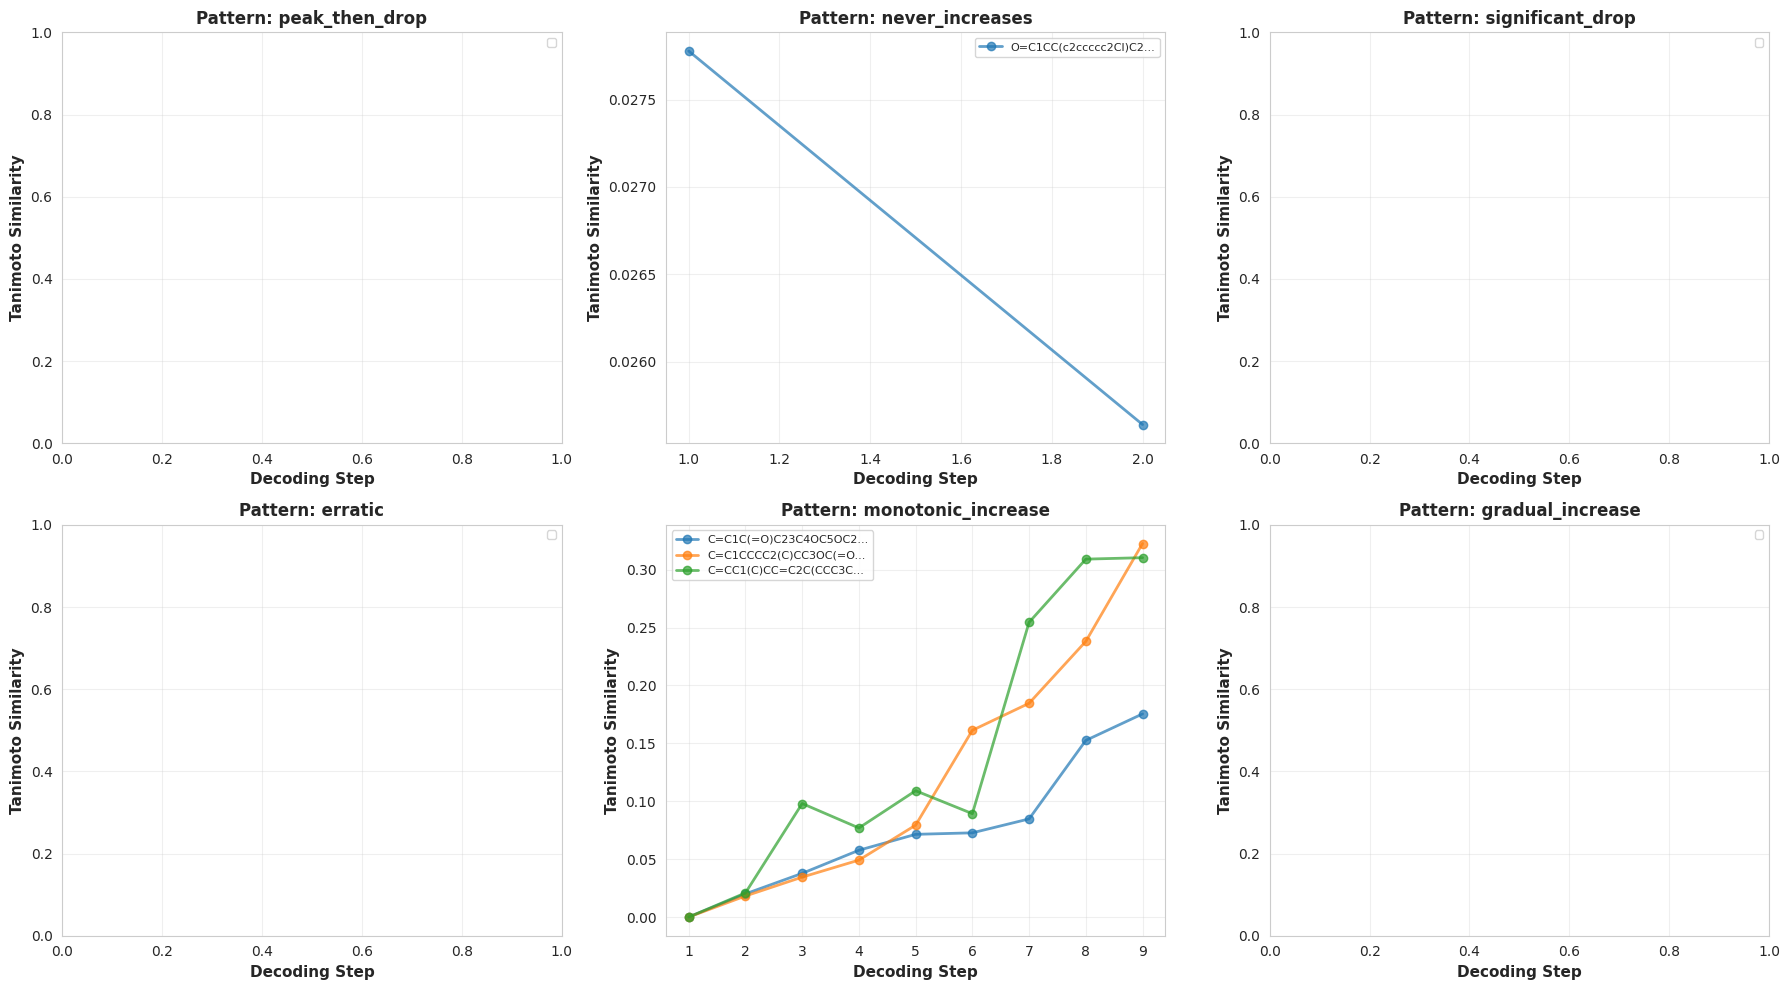


Generating summary statistics...
PARTIAL DECODING ANALYSIS SUMMARY

1. OVERALL STATISTICS
--------------------------------------------------------------------------------
Total molecules analyzed: 100
Total decoding steps recorded: 491
Average steps per molecule: 4.91

2. SIMILARITY METRICS
--------------------------------------------------------------------------------
Mean Tanimoto similarity: 0.1679 ± 0.1886
Median Tanimoto similarity: 0.1163
Mean atom coverage: 0.2683 ± 0.2127

3. PROGRESSION PATTERN DISTRIBUTION
--------------------------------------------------------------------------------
monotonic_increase       :   95 (95.00%)
insufficient_data        :    4 ( 4.00%)
never_increases          :    1 ( 1.00%)

4. FAILURE MODE ANALYSIS
--------------------------------------------------------------------------------
Total failure cases: 1 (1.00%)

never_increases:
  Count: 1
  Mean max similarity: 0.0278
  Mean final similarity: 0.0256
  Mean drop magnitude: 0.0021

5. SUCCESS M

In [9]:
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
from collections import defaultdict

def extract_encoder_representations(model, smiles_list, vocab, atom_vocab, batch_size=10):
    dataset = MoleculeDataset(smiles_list, vocab, atom_vocab, batch_size)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0,
                       collate_fn=lambda x: x[0])

    all_root_vecs = []
    all_smiles = []

    flat_smiles = [smi for batch in dataset.batches for smi in batch]

    with torch.no_grad():
        batch_idx = 0
        for batch in tqdm(loader, desc="Encoder representations"):
            graphs, tensors, orders = batch
            tree_tensors, graph_tensors = hgnn.make_cuda(tensors)
            root_vecs, tree_vecs, _, graph_vecs = model.encoder(tree_tensors, graph_tensors)
            root_vecs, _ = model.rsample(root_vecs, model.R_mean, model.R_var, perturb=False)

            start = batch_size * batch_idx
            end = min(batch_size * (batch_idx + 1), len(flat_smiles))
            batch_smiles = flat_smiles[start:end]

            for i, smi in enumerate(batch_smiles):
                all_root_vecs.append(root_vecs[i].cpu().numpy())
                all_smiles.append(smi)

            batch_idx += 1

    return np.array(all_root_vecs), all_smiles

encoder_vecs, valid_smiles = extract_encoder_representations(
    model, test_smiles, args.vocab, common_atom_vocab, batch_size=10
)

def get_molecular_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    try:
        return {
            'num_atoms': mol.GetNumAtoms(),
            'num_bonds': mol.GetNumBonds(),
            'num_rings':  Chem.GetSSSR(mol).__len__(),
            'num_aromatic_rings':  Descriptors.NumAromaticRings(mol),
            'num_heteroatoms':  Descriptors.NumHeteroatoms(mol),
            'molecular_weight': Descriptors.MolWt(mol),
            'logp': Descriptors.MolLogP(mol),
            'tpsa': Descriptors.TPSA(mol),
            'num_rotatable_bonds':  Descriptors.NumRotatableBonds(mol),
            'num_hbd': Descriptors.NumHDonors(mol),
            'num_hba': Descriptors.NumHAcceptors(mol),
        }
    except:
        return None

print("\nExtracting molecular properties...")
mol_properties = []
valid_indices = []
for i, smi in enumerate(tqdm(valid_smiles, desc="Getting properties")):
    props = get_molecular_properties(smi)
    if props is not None:
        mol_properties.append(props)
        valid_indices.append(i)

# Filter to keep only molecules with valid properties
encoder_vecs = encoder_vecs[valid_indices]
valid_smiles = [valid_smiles[i] for i in valid_indices]

def get_substructure_similarity(target_smi, partial_smi):
    try:
        target_mol = Chem.MolFromSmiles(target_smi)
        partial_mol = Chem.MolFromSmiles(partial_smi)
        if target_mol is None or partial_mol is None:
            return None, None

        tanimoto = calculate_tanimoto(target_smi, partial_smi)

        #atom coverage
        target_atoms = target_mol.GetNumAtoms()
        partial_atoms = partial_mol.GetNumAtoms()
        coverage = min(partial_atoms / target_atoms, 1.0)

        return tanimoto, coverage
    except:
        return None, None

def calculate_tanimoto(smi1, smi2):
    try:
        mol1 = Chem.MolFromSmiles(smi1)
        mol2 = Chem.MolFromSmiles(smi2)
        if mol1 is None or mol2 is None:
            return None
        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2, nBits=2048)
        fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, nBits=2048)
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    except:
        return None

def analyze_decoding_progression(model, smiles_list, vocab, atom_vocab, max_molecules=50):
    results = []

    for smi in tqdm(smiles_list[: max_molecules], desc="Analyzing decoding"):
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                continue

            hmol = MolGraph(smi)
            num_motifs = len(hmol.mol_tree.nodes())

            if num_motifs < 2:
                continue

            total_atoms = mol.GetNumAtoms()

            for step in range(1, min(num_motifs + 1, 10)):
                frac = step / num_motifs
                n_atoms_partial = max(1, int(total_atoms * frac))

                visited = set([0])
                queue = [0]
                while len(visited) < n_atoms_partial and queue:
                    curr = queue.pop(0)
                    atom = mol.GetAtomWithIdx(curr)
                    for neighbor in atom.GetNeighbors():
                        nidx = neighbor.GetIdx()
                        if nidx not in visited:
                            visited.add(nidx)
                            queue.append(nidx)
                            if len(visited) >= n_atoms_partial:
                                break

                try:
                    partial_smi = Chem.MolFragmentToSmiles(mol, list(visited))
                    tanimoto, coverage = get_substructure_similarity(smi, partial_smi)

                    if tanimoto is not None:
                        results.append({
                            'original_smiles': smi,
                            'step': step,
                            'num_motifs': num_motifs,
                            'fraction_complete': frac,
                            'tanimoto': tanimoto,
                            'atom_coverage': coverage,
                            'partial_smiles': partial_smi
                        })
                except:
                    continue

        except Exception as e:
            continue

    return pd.DataFrame(results)

decoding_df = analyze_decoding_progression(
    model, valid_smiles, args.vocab, common_atom_vocab, max_molecules=100
)

def categorize_progression_pattern(group_df):
    """
    Categorize the decoding progression pattern for a molecule.

    Returns:
    - pattern: str indicating the progression type
    - max_similarity: peak Tanimoto similarity achieved
    - final_similarity: Tanimoto at the last step
    - drop_magnitude: how much similarity dropped from peak (if applicable)
    """
    if len(group_df) < 2:
        return 'insufficient_data', None, None, None

    tanimoto_values = group_df['tanimoto'].values
    steps = group_df['step'].values

    max_sim = tanimoto_values.max()
    final_sim = tanimoto_values[-1]
    max_idx = tanimoto_values.argmax()

    # Calculate trend
    correlation, _ = pearsonr(steps, tanimoto_values)

    # Detect patterns
    drop_magnitude = max_sim - final_sim

    if correlation > 0.7:
        pattern = 'monotonic_increase'  # Good progression
    elif correlation < -0.3 and max_idx < len(tanimoto_values) - 2:
        pattern = 'peak_then_drop'  # Failure mode
    elif max_sim < 0.3:
        pattern = 'never_increases'  # Severe failure
    elif drop_magnitude > 0.2:
        pattern = 'significant_drop'  # Moderate failure
    elif abs(correlation) < 0.3:
        pattern = 'erratic'  # Unstable progression
    else:
        pattern = 'gradual_increase'  # Normal progression

    return pattern, max_sim, final_sim, drop_magnitude


def analyze_failure_modes(decoding_df):
    """
    Analyze and categorize failure modes in decoding progression.
    """
    failure_analysis = []

    for smi, group in decoding_df.groupby('original_smiles'):
        group = group.sort_values('step')
        pattern, max_sim, final_sim, drop_mag = categorize_progression_pattern(group)

        failure_analysis.append({
            'smiles': smi,
            'pattern': pattern,
            'max_similarity': max_sim,
            'final_similarity': final_sim,
            'drop_magnitude': drop_mag,
            'num_steps': len(group),
            'num_motifs': group['num_motifs'].iloc[0]
        })

    return pd.DataFrame(failure_analysis)


def plot_decoding_progression_analysis(decoding_df, failure_df, output_prefix='decoding_analysis'):
    """
    Create comprehensive visualization of decoding progression.
    """

    # Set up the plotting style
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (20, 12)

    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # 1. Overall progression: Tanimoto vs Step (averaged)
    ax1 = fig.add_subplot(gs[0, :2])
    step_stats = decoding_df.groupby('step').agg({
        'tanimoto': ['mean', 'std', 'count']
    }).reset_index()
    step_stats.columns = ['step', 'mean_tanimoto', 'std_tanimoto', 'count']

    ax1.plot(step_stats['step'], step_stats['mean_tanimoto'],
             'o-', linewidth=2, markersize=8, label='Mean Tanimoto')
    ax1.fill_between(step_stats['step'],
                     step_stats['mean_tanimoto'] - step_stats['std_tanimoto'],
                     step_stats['mean_tanimoto'] + step_stats['std_tanimoto'],
                     alpha=0.3, label='±1 std')
    ax1.set_xlabel('Decoding Step', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Tanimoto Similarity', fontsize=12, fontweight='bold')
    ax1.set_title('Average Decoding Progression Across All Molecules',
                  fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Pattern distribution
    ax2 = fig.add_subplot(gs[0, 2])
    pattern_counts = failure_df['pattern'].value_counts()
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(pattern_counts)))
    ax2.barh(range(len(pattern_counts)), pattern_counts.values, color=colors)
    ax2.set_yticks(range(len(pattern_counts)))
    ax2.set_yticklabels(pattern_counts.index, fontsize=10)
    ax2.set_xlabel('Count', fontsize=11, fontweight='bold')
    ax2.set_title('Progression Pattern Distribution', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')

    # 3. Individual trajectories colored by pattern
    ax3 = fig.add_subplot(gs[1, :])

    pattern_colors = {
        'monotonic_increase': 'green',
        'gradual_increase': 'lightgreen',
        'erratic': 'orange',
        'significant_drop': 'red',
        'peak_then_drop': 'darkred',
        'never_increases': 'purple'
    }

    # Sample molecules from each pattern
    for pattern in pattern_colors.keys():
        pattern_molecules = failure_df[failure_df['pattern'] == pattern]['smiles'].values[:5]
        for smi in pattern_molecules:
            mol_data = decoding_df[decoding_df['original_smiles'] == smi].sort_values('step')
            ax3.plot(mol_data['step'], mol_data['tanimoto'],
                    alpha=0.6, linewidth=1.5, color=pattern_colors[pattern])

    # Create legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color=color, linewidth=2, label=pattern)
                      for pattern, color in pattern_colors.items()]
    ax3.legend(handles=legend_elements, loc='lower right', fontsize=10)
    ax3.set_xlabel('Decoding Step', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Tanimoto Similarity', fontsize=12, fontweight='bold')
    ax3.set_title('Individual Molecule Trajectories (5 per pattern)',
                  fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)

    # 4. Correlation: Fraction complete vs Tanimoto
    ax4 = fig.add_subplot(gs[2, 0])
    scatter_sample = decoding_df.sample(min(1000, len(decoding_df)))
    ax4.hexbin(scatter_sample['fraction_complete'], scatter_sample['tanimoto'],
              gridsize=30, cmap='YlOrRd', mincnt=1)
    ax4.set_xlabel('Fraction Complete', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Tanimoto Similarity', fontsize=11, fontweight='bold')
    ax4.set_title('Similarity vs. Completion', fontsize=12, fontweight='bold')

    # 5. Atom coverage vs Tanimoto
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.hexbin(scatter_sample['atom_coverage'], scatter_sample['tanimoto'],
              gridsize=30, cmap='YlGnBu', mincnt=1)
    ax5.set_xlabel('Atom Coverage', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Tanimoto Similarity', fontsize=11, fontweight='bold')
    ax5.set_title('Similarity vs. Atom Coverage', fontsize=12, fontweight='bold')

    # 6. Final similarity distribution by pattern
    ax6 = fig.add_subplot(gs[2, 2])
    failure_df_clean = failure_df[failure_df['final_similarity'].notna()]
    patterns_to_plot = failure_df_clean['pattern'].value_counts().head(6).index
    data_to_plot = [failure_df_clean[failure_df_clean['pattern'] == p]['final_similarity'].values
                    for p in patterns_to_plot]

    bp = ax6.boxplot(data_to_plot, labels=patterns_to_plot, patch_artist=True)
    for patch, pattern in zip(bp['boxes'], patterns_to_plot):
        patch.set_facecolor(pattern_colors.get(pattern, 'gray'))
    ax6.set_xticklabels(patterns_to_plot, rotation=45, ha='right', fontsize=9)
    ax6.set_ylabel('Final Tanimoto', fontsize=11, fontweight='bold')
    ax6.set_title('Final Similarity by Pattern', fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(f'{output_prefix}_comprehensive.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create a second figure for detailed failure mode examples
    plot_failure_mode_examples(decoding_df, failure_df, output_prefix)

    return fig


def plot_failure_mode_examples(decoding_df, failure_df, output_prefix='decoding_analysis'):
    """
    Plot detailed examples of each failure mode.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    failure_patterns = ['peak_then_drop', 'never_increases', 'significant_drop',
                       'erratic', 'monotonic_increase', 'gradual_increase']

    for idx, pattern in enumerate(failure_patterns):
        ax = axes[idx]
        pattern_mols = failure_df[failure_df['pattern'] == pattern]['smiles'].values[:3]

        for smi in pattern_mols:
            mol_data = decoding_df[decoding_df['original_smiles'] == smi].sort_values('step')
            ax.plot(mol_data['step'], mol_data['tanimoto'],
                   'o-', linewidth=2, markersize=6, alpha=0.7, label=smi[:20]+'...')

        ax.set_xlabel('Decoding Step', fontsize=11, fontweight='bold')
        ax.set_ylabel('Tanimoto Similarity', fontsize=11, fontweight='bold')
        ax.set_title(f'Pattern: {pattern}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.savefig(f'{output_prefix}_failure_modes.png', dpi=300, bbox_inches='tight')
    plt.show()


def generate_summary_statistics(decoding_df, failure_df):
    """
    Generate comprehensive summary statistics.
    """
    print("="*80)
    print("PARTIAL DECODING ANALYSIS SUMMARY")
    print("="*80)

    print("\n1. OVERALL STATISTICS")
    print("-" * 80)
    print(f"Total molecules analyzed: {decoding_df['original_smiles'].nunique()}")
    print(f"Total decoding steps recorded: {len(decoding_df)}")
    print(f"Average steps per molecule: {len(decoding_df) / decoding_df['original_smiles'].nunique():.2f}")

    print("\n2. SIMILARITY METRICS")
    print("-" * 80)
    print(f"Mean Tanimoto similarity: {decoding_df['tanimoto'].mean():.4f} ± {decoding_df['tanimoto'].std():.4f}")
    print(f"Median Tanimoto similarity: {decoding_df['tanimoto'].median():.4f}")
    print(f"Mean atom coverage: {decoding_df['atom_coverage'].mean():.4f} ± {decoding_df['atom_coverage'].std():.4f}")

    print("\n3. PROGRESSION PATTERN DISTRIBUTION")
    print("-" * 80)
    pattern_dist = failure_df['pattern'].value_counts()
    for pattern, count in pattern_dist.items():
        pct = 100 * count / len(failure_df)
        print(f"{pattern:25s}: {count:4d} ({pct:5.2f}%)")

    print("\n4. FAILURE MODE ANALYSIS")
    print("-" * 80)
    failure_patterns = ['peak_then_drop', 'never_increases', 'significant_drop', 'erratic']
    total_failures = failure_df[failure_df['pattern'].isin(failure_patterns)]
    print(f"Total failure cases: {len(total_failures)} ({100*len(total_failures)/len(failure_df):.2f}%)")

    for pattern in failure_patterns:
        pattern_data = failure_df[failure_df['pattern'] == pattern]
        if len(pattern_data) > 0:
            print(f"\n{pattern}:")
            print(f"  Count: {len(pattern_data)}")
            print(f"  Mean max similarity: {pattern_data['max_similarity'].mean():.4f}")
            print(f"  Mean final similarity: {pattern_data['final_similarity'].mean():.4f}")
            if 'drop_magnitude' in pattern_data.columns:
                print(f"  Mean drop magnitude: {pattern_data['drop_magnitude'].mean():.4f}")

    print("\n5. SUCCESS MODE ANALYSIS")
    print("-" * 80)
    success_patterns = ['monotonic_increase', 'gradual_increase']
    for pattern in success_patterns:
        pattern_data = failure_df[failure_df['pattern'] == pattern]
        if len(pattern_data) > 0:
            print(f"\n{pattern}:")
            print(f"  Count: {len(pattern_data)}")
            print(f"  Mean final similarity: {pattern_data['final_similarity'].mean():.4f}")

    print("\n6. STEP-WISE PROGRESSION")
    print("-" * 80)
    step_progression = decoding_df.groupby('step')['tanimoto'].agg(['mean', 'std', 'count'])
    print(step_progression.head(10))

    print("\n" + "="*80)

    return {
        'overall': {
            'n_molecules': decoding_df['original_smiles'].nunique(),
            'n_steps': len(decoding_df),
            'mean_tanimoto': decoding_df['tanimoto'].mean(),
            'std_tanimoto': decoding_df['tanimoto'].std()
        },
        'patterns': pattern_dist.to_dict(),
        'failure_rate': len(total_failures) / len(failure_df)
    }


# Run the complete analysis
print("Analyzing failure modes...")
failure_df = analyze_failure_modes(decoding_df)

print("\nGenerating visualizations...")
plot_decoding_progression_analysis(decoding_df, failure_df)

print("\nGenerating summary statistics...")
summary_stats = generate_summary_statistics(decoding_df, failure_df)